## PyTorch Tutorial!!!
In this assignment, you will be familiarized with the usage of the PyTorch library and how to build a model in two ways  
It's quite similar to TensorFlow
*   using the inbuilt layers in pytorch
*   using custom layers to replicate the same result

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
# Using the GPU if it exists

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


### Loading and preprocessing the Data
We will directly be using the dataset included in literally any library that exists. MNIST really is THAT popular.  
Link: https://docs.pytorch.org/vision/0.9/datasets.html#mnist

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

## Making a simple feedforward network

The following is a simple feedforward model with three layers:
* a flatten layer to convert our 28x28 images into a single array of length 784
* a dense layer of 128 neurons with the relu activation function
* finally a dense layer of 10 neurons with the softmax activation to get a distribution between the digits

In [8]:
# Build the model
SequentialNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

### Training and Testing loops

In [9]:
# Training loop
def train(model, loader, optimizer, loss_fn, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Testing loop
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")


### Training the sequential model

In [10]:
print("\nTraining SequentialNet")
sequential_model = SequentialNet.to(device)
optimizer_seq = optim.Adam(sequential_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


train(sequential_model, train_loader, optimizer_seq, loss_fn)
test(sequential_model, test_loader)


Training SequentialNet
Epoch 1, Loss: 364.2011
Epoch 2, Loss: 182.3455
Epoch 3, Loss: 132.2456
Epoch 4, Loss: 106.2123
Epoch 5, Loss: 88.0418
Accuracy: 96.83%


### Manually building the same network from scratch
You can use the simple sequential model we described above as a reference.

In [11]:
# Custom model
class ManualNet(nn.Module):
    def __init__(self):
        super(ManualNet, self).__init__()
        self.linear1 = nn.Linear(784, 128) 
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.linear1(x)
        out = torch.relu(out)
        out = self.linear2(out)
        out = torch.relu(out)
        out = self.linear3(out)
        return out 

### Training the manual model

In [12]:
print("\nTraining ManualNet")

manual_model = ManualNet().to(device)
optimizer_manual = optim.SGD(manual_model.parameters(), lr=0.01, momentum=0.9)
train(manual_model, train_loader, optimizer_manual, loss_fn)
test(manual_model, test_loader)


Training ManualNet
Epoch 1, Loss: 397.3209
Epoch 2, Loss: 174.2397
Epoch 3, Loss: 126.6706
Epoch 4, Loss: 98.8812
Epoch 5, Loss: 85.4373
Accuracy: 96.53%


### Visualize the outputs of the models

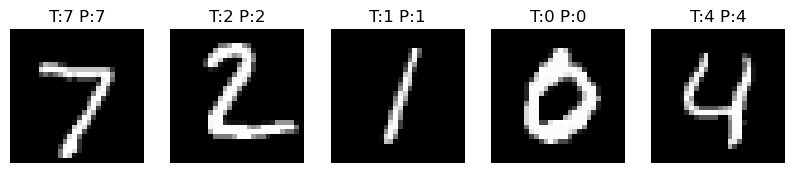

In [13]:
def visualize(model, loader, n=5):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    preds = model(x).argmax(dim=1)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x[i].cpu().squeeze(), cmap='gray')
        plt.title(f"T:{y[i].item()} P:{preds[i].item()}")
        plt.axis('off')
    plt.show()

# visualize(manual_model, test_loader) # Uncomment this later
visualize(sequential_model, test_loader)

## Assignment
* Load and preprocess CIFAR100 dataset (not CIFAR10)
* Build a feedforward network for it. You can experiment around with number of layers and and neurons in each layer and different activation functions
* You are allowed to use nn.functional. (convolutions _might_ make your accuracy better)

In [14]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

100%|██████████| 169M/169M [00:32<00:00, 5.15MB/s] 


In [15]:
import torch

def train(model, loader, optimizer, loss_fn, epochs=100, lr=0.001):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

def test(model, loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [16]:
import torch.nn.functional as F

class CIFAR100(nn.Module):
    def __init__(self):
        super(CIFAR100, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256*2*2, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout_conv(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [17]:
model = CIFAR100().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimizer, loss_fn)
test(model, test_loader) 

Epoch 1, Loss: 1535.2419
Epoch 2, Loss: 1305.9144
Epoch 3, Loss: 1182.2556
Epoch 4, Loss: 1107.1687
Epoch 5, Loss: 1047.8909
Epoch 6, Loss: 1001.8396
Epoch 7, Loss: 956.6226
Epoch 8, Loss: 921.0897
Epoch 9, Loss: 888.4357
Epoch 10, Loss: 862.3879
Epoch 11, Loss: 836.5938
Epoch 12, Loss: 813.2625
Epoch 13, Loss: 789.1162
Epoch 14, Loss: 771.4084
Epoch 15, Loss: 749.2903
Epoch 16, Loss: 733.0917
Epoch 17, Loss: 717.2087
Epoch 18, Loss: 704.3856
Epoch 19, Loss: 688.0935
Epoch 20, Loss: 674.7924
Epoch 21, Loss: 661.3446
Epoch 22, Loss: 649.6825
Epoch 23, Loss: 637.1183
Epoch 24, Loss: 625.3517
Epoch 25, Loss: 610.8455
Epoch 26, Loss: 601.1119
Epoch 27, Loss: 593.5717
Epoch 28, Loss: 581.7809
Epoch 29, Loss: 571.1158
Epoch 30, Loss: 565.1224
Epoch 31, Loss: 554.3727
Epoch 32, Loss: 547.1971
Epoch 33, Loss: 538.8946
Epoch 34, Loss: 533.3731
Epoch 35, Loss: 522.7547
Epoch 36, Loss: 514.0877
Epoch 37, Loss: 513.2788
Epoch 38, Loss: 503.4665
Epoch 39, Loss: 495.9499
Epoch 40, Loss: 493.1162
Epo

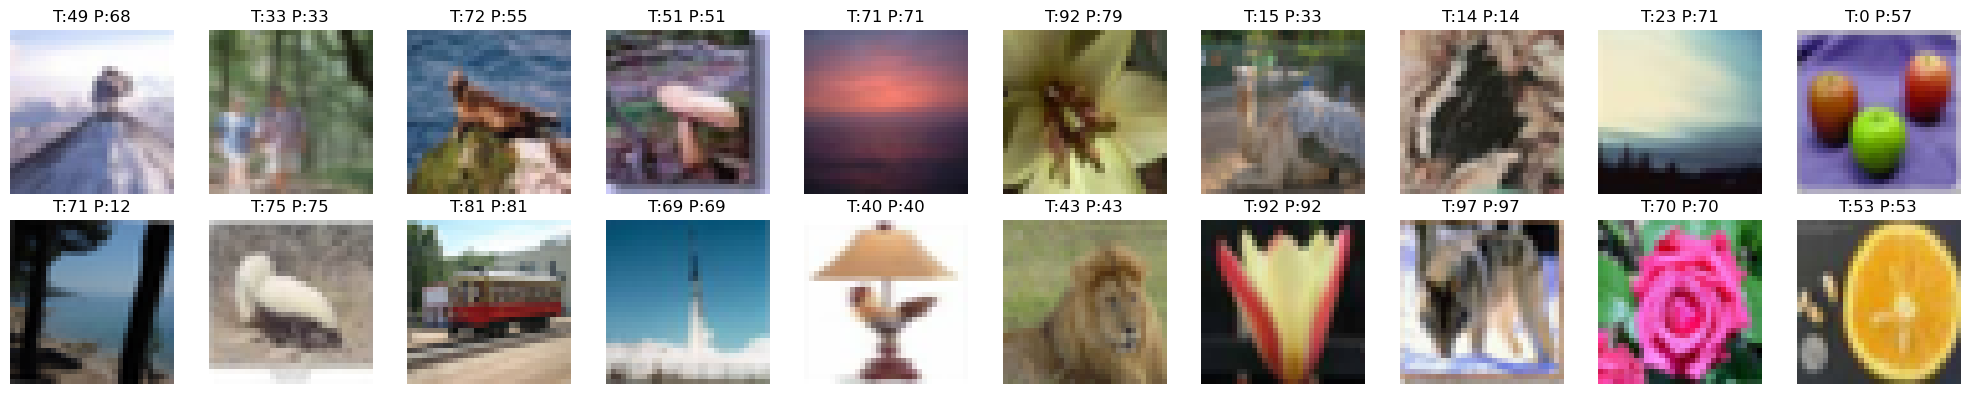

In [18]:
def visualize(model, loader, n=20):
    model = model.to(device)
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    preds = model(x).argmax(dim=1)

    plt.figure(figsize=(2*(n//2), 4))  # Adjust width and height for two rows
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        mean = torch.tensor([0.5071, 0.4867, 0.4408]).reshape(1, 1, 3)
        std = torch.tensor([0.2675, 0.2565, 0.2761]).reshape(1, 1, 3)
        img = x[i].cpu().permute(1, 2, 0) 
        img = img * std + mean        
        img = torch.clamp(img, 0, 1)     
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.title(f"T:{y[i].item()} P:{preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

try:
    visualize(model, test_loader)
except NameError:
    print("Model 'model' is not defined. Please run the cell where you define 'model'.")

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Bonus Assignment
* Try the solving the "Titanic Survival Prediction" dataset from kaggle